<a href="https://colab.research.google.com/github/yaramohamadi/dermo-segmentation/blob/master/all_in_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import random
import time
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.util import view_as_blocks
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from math import floor, ceil
from skimage.filters import rank
from skimage.morphology import disk, dilation
from skimage.feature import canny
from skimage.util import view_as_blocks, view_as_windows
from sklearn.metrics import roc_curve, auc
import re
from math import ceil
from scipy.ndimage import gaussian_filter, map_coordinates, rotate

In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
input('wanna overwrite?')

im_dir = '/content/drive/My Drive/warwick/dataset'
writer = '/content/drive/My Drive/warwick/train_edge.tfrecords'
#writer = tf.python_io.TFRecordWriter(writer)

patch_size = (128, 128)

write_or_percentile = 1

stat = {
    '0': 0,
    '1:20': 0,
    '20:40': 0,
    '40:60': 0,
    '60:80': 0,
    '80:100': 0
}

train_files = 85 + 1
test_files = 60 + 1
dataset_size = 0

def int64_feature(_value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[_value]))


def bytes_feature(_value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[_value]))

gt_1_fraction, gt_0_fraction, brd_fraction, sep_fraction = 0, 0, 0, 0

for i in range(1, train_files): 

    print(i)
    train_file = 'train_' + str(i) + '.bmp'
    label_file = 'train_' + str(i) + '_anno_edge.bmp'

    # read and normalize
    gt = imageio.imread(os.path.join(im_dir, label_file))
    s = imageio.imread(os.path.join(im_dir, train_file))
    # histogram equalization accross the red channel
    #s[:,:,0] = rank.equalize(s[:,:,0], selem = disk(patch_size[0]))
    mean = np.mean(s)
    std = np.std(s)
    s = (s - mean) / std

    # cropping
    h_o = (len(s) % patch_size[0]) / 2
    w_o = (len(s[0]) % patch_size[1]) / 2
    x_s, y_s = floor(w_o), floor(h_o)
    h_new, w_new = int(len(s)/patch_size[0])*patch_size[0], int(len(s[0])/patch_size[1])*patch_size[1]
    s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
    gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]

    gt0 = gt == 0
    gt1 = gt == 1
    gt2 = gt == 2
    gt3 = gt == 3

    #___
    image = np.dstack((s, gt))
    image_patches = extract_patches_2d(image, patch_size, 300)

    for instance in image_patches:
        img_patch = instance[:, :, :-1]
        gt_patch = instance[:, :, -1]

        ratio = np.sum(gt_patch[ gt_patch == 1]) / (patch_size[0] * patch_size[1])

        flag = 0

        if ratio == 0:
            if random.random() < 1 :
                stat['0'] += 1
                flag = 1
        elif ratio < 0.2:
            if random.random() < 0.7867459643:
                stat['1:20'] += 1
                flag = 1
        elif ratio < 0.4:
            if random.random() < 0.61589624210:
                stat['20:40'] += 1
                flag = 1
        elif ratio < 0.6:
            if random.random() <  0.450827653359:
                stat['40:60'] += 1
                flag = 1
        elif ratio < 0.8:
            if random.random() < 0.59896507115:
                stat['60:80'] += 1
                flag = 1
        else:
            if random.random() < 0.7158871279474:
                stat['80:100'] += 1
                flag = 1

        if flag:
            dataset_size += 1

            #class weighting
            gt_ones = np.sum( gt_patch == 1) 
            gt_zeros = np.sum(gt_patch == 0)
            im_size = patch_size[0] * patch_size[1]
            gt_1_fraction += gt_ones/im_size
            gt_0_fraction += gt_zeros/im_size

            sep_ones = np.sum( gt_patch == 2)
            sep_fraction += sep_ones/im_size

            brd_ones = np.sum( gt_patch == 3)
            brd_fraction += brd_ones/im_size

            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        'image': bytes_feature(img_patch.astype(np.float32).tostring()),
                        'label': bytes_feature(gt_patch.astype(np.int32).tostring())
                    }
                ))
            writer.write(example.SerializeToString())


#writer.close()

print("Success...")
print("Dataset size : ")
print(dataset_size)
for key, value in stat.items():
    print(key, ' ----> ', value)

gt_ones_percentile = gt_1_fraction / dataset_size
gt_ones_percentile = gt_0_fraction / dataset_size
sep_ones_percentile = sep_fraction / dataset_size
brd_ones_percentile = brd_fraction / dataset_size

print("GT percentile " + str(gt_ones_percentile))
print("SEP percentile " + str(sep_ones_percentile))
print("BRD percentile " + str(brd_ones_percentile))


#128 - 300 patches per image
#0  ---->  1852  1
#1:20  ---->  2354  0.7867459643
#20:40  ---->  3007  0.61589624210
#40:60  ---->  4108  0.450827653359
#60:80  ---->  3092  0.59896507115
#80:100  ---->  2587  0.7158871279474



wanna overwrite?
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
Success...
Dataset size : 
16770
0  ---->  2764
1:20  ---->  2772
20:40  ---->  2735
40:60  ---->  2852
60:80  ---->  2833
80:100  ---->  2814
GT percentile 0.0
SEP percentile 0.01818363232916853
BRD percentile 0.10746981871575917


In [0]:
gt_ones_percentile = gt_1_fraction / dataset_size
gt_zeros_percentile = gt_0_fraction / dataset_size
sep_ones_percentile = sep_fraction / dataset_size
brd_ones_percentile = brd_fraction / dataset_size

print("GT percentile " + str(gt_ones_percentile))
print("BG percentile " + str(gt_zeros_percentile))
print("SEP percentile " + str(sep_ones_percentile))
print("BRD percentile " + str(brd_ones_percentile))


GT percentile 0.4225934059902821
BG percentile 0.4517531429647902
SEP percentile 0.01818363232916853
BRD percentile 0.10746981871575917


(?, 128, 128, 3)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 256)
(?, 8, 8, 512)
(?, 4, 4, 512)
(?, 4, 4, 4)
(?, 128, 128, 4)
(?, 128, 128, 4)
(?, 128, 128, 4)
(?, 128, 128, 4)
(?, 128, 128, 4)
(?, 128, 128, 4)
Trying to restore last checkpoint ...
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/warwick/checkpoints_edge/best_validation
Restored checkpoint from: /content/drive/My Drive/warwick/checkpoints_edge/best_validation
Starting Epoch   161
Best Dice    0.8721
Current Dice 0.8523


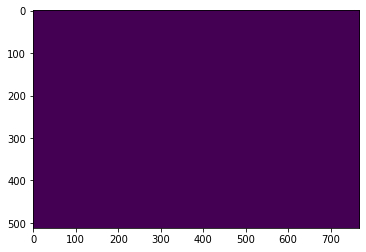

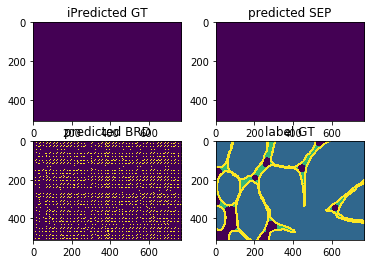

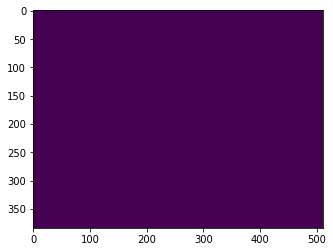

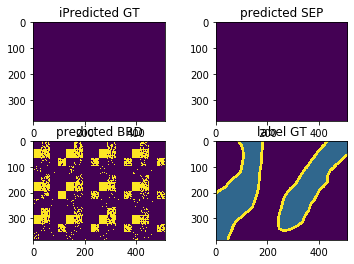

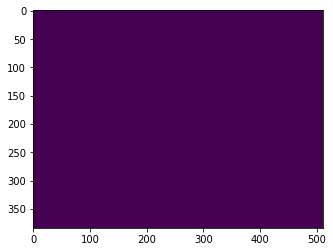

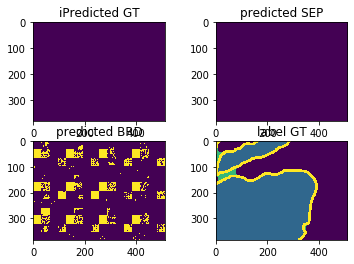

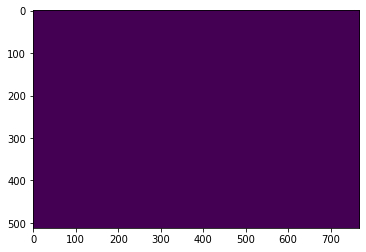

KeyboardInterrupt: ignored

In [47]:
train_file = '/content/drive/My Drive/warwick/train_edge.tfrecords'

result_images_file = '/content/drive/My Drive/warwick/results_edge/%d'
result_images_folder = '/content/drive/My Drive/warwick/results_edge'
im_dir = '/content/drive/My Drive/warwick/dataset/'
stat_file = '/content/drive/My Drive/warwick/results_edge.txt'

save_path = '/content/drive/My Drive/warwick/checkpoints_edge/best_validation'
load_dir = '/content/drive/My Drive/warwick/checkpoints_edge/'
save_path_test = '/content/drive/My Drive/warwick/checkpoints_test_edge/best_validation'
load_dir_test = '/content/drive/My Drive/warwick/checkpoints_test_edge/'

pad_amount = 0
middle_point = (128, 128)
patch_size = (128 + pad_amount, 128 + pad_amount)
step_size = (128 - pad_amount, 128 - pad_amount)

lr = 0.0001
skip_connection_out_size = (int(ceil(patch_size[0])), int(ceil(patch_size[1])))

tf.reset_default_graph()

sess = tf.Session()

def parse_function(example_proto):
    features = {
        'label': tf.FixedLenFeature((), tf.string, default_value=""),
        'image': tf.FixedLenFeature((), tf.string, default_value="")
    }
    parsed_features = tf.parse_single_example(example_proto, features)

    lbl = tf.reshape(tf.decode_raw(parsed_features['label'], tf.int32), shape=[patch_size[0], patch_size[1]])
    img = tf.reshape(tf.decode_raw(parsed_features['image'], tf.float32), shape=[patch_size[0], patch_size[1], 3])

    return img, lbl


def read_data():
    training_data_set = tf.data.TFRecordDataset(train_file)
    training_data_set = training_data_set.shuffle(buffer_size=1000, seed=int(time.time()))
    training_data_set = training_data_set.map(parse_function)
    training_data_set.repeat()
    training_data_set = training_data_set.batch(batch_size=20)
    training_data_set = training_data_set.prefetch(tf.data.experimental.AUTOTUNE)
    test_data_set = tf.data.Dataset.from_tensor_slices((input_patches, input_labels))
    #test_data_set = tf.data.TFRecordDataset('../test_image.tfrecords')
    #test_data_set = test_data_set.map(parse_function)
    test_data_set = test_data_set.batch(batch_size=100)
    #test_data_set = test_data_set.prefetch(tf.data.experimental.AUTOTUNE)
    iterator = tf.data.Iterator.from_structure(output_types=training_data_set.output_types,
                                               output_shapes=training_data_set.output_shapes)
    training_init_op = iterator.make_initializer(training_data_set)
    test_init_op = iterator.make_initializer(test_data_set)
    next_element = iterator.get_next()
    return training_init_op, test_init_op, next_element


def train(c):
    sess.run(train_init)
    while True:
        try:
            sess.run(train_step, feed_dict={is_training: True})
        except tf.errors.OutOfRangeError:
            break
    print(time.strftime('%H:%M:%S', time.gmtime(time.time() - c)))



def evaluate(epoch):
    if not os.path.exists(os.path.join(result_images_file % epoch)):
        os.mkdir(os.path.join(result_images_file % epoch))
    stat_dict = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }
    stat_dict2 = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }
    stat_dict3 = {  # keeps track of the evaluation results
        'tp': 0,
        'tn': 0,
        'fp': 0,
        'fn': 0
    }

    y_label = []
    y_scores = []
    train_files = 85 + 1
    test_files = 60 + 1
    dataset_size = 0

    import random
    randvalue = random.randint(1, 60)

    for i in range(1, test_files): 

      im_file = 'testA_' + str(i) + '.bmp'
      gt_file = 'testA_' + str(i) + '_anno_edge.bmp'

      #read and normalize
      s = imageio.imread(os.path.join(im_dir, im_file))
      #s[:,:,0] = rank.equalize(s[:,:,0], selem = disk(patch_size[0]))
      mean = np.mean(s)
      std = np.std(s)
      s = (s - mean) / std
      gt = imageio.imread(os.path.join(im_dir, gt_file)).astype(np.uint8)

      # width and height offset to cut out to be able to divide image into correct patch sizes
      h_o = (len(s) % patch_size[0]) / 2
      w_o = (len(s[0]) % patch_size[1]) / 2
      x_s, y_s = floor(w_o), floor(h_o)
      h_new, w_new = int(len(s)/patch_size[0])*patch_size[0], int(len(s[0])/patch_size[1])*patch_size[1]
      s = s[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new, :]
      gt = gt[floor(y_s):floor(y_s)+h_new, floor(x_s):floor(x_s)+w_new]

      image_patches = view_as_blocks(s, (patch_size[0], patch_size[1], 3)).reshape(-1, middle_point[0], middle_point[1], 3)
      gt_patches = view_as_blocks(gt, (patch_size[0], patch_size[1])).reshape(-1, middle_point[0], middle_point[1])

      sess.run(test_init, feed_dict={input_patches: image_patches, input_labels: gt_patches})

      fcn_output = []
      while True:
          try:
              fcn_output.append(sess.run(output, feed_dict={is_training: False}))
          except tf.errors.OutOfRangeError:
              break
        #___________________________________________________________________________________________
        #___Holding into account stepsize and overlappings (cropping is done, no average taken)____#

      fcn_output = np.concatenate(fcn_output, axis=0) 

      fcn_output = np.array(fcn_output)

      num_col = gt.shape[1] // middle_point[1]
      num_row = gt.shape[0] // middle_point[0]

      scores = fcn_output[:, :, :, 1]
      scores = scores.reshape(-1, middle_point[0], middle_point[1])
      predictions = np.argmax(fcn_output, axis=-1)
      
      scores = scores.reshape(num_row, num_col, middle_point[0], middle_point[1])
      predictions = predictions.reshape(num_row, num_col, middle_point[0], middle_point[1])
      predictions = predictions.swapaxes(2, 1)
      prediction = predictions.reshape(num_row*middle_point[0], num_col*middle_point[1])
      scores = scores.swapaxes(2, 1)
      score = scores.reshape(num_row*middle_point[0], num_col*middle_point[1])
      #___________________________________________________________________________________________

      #generated_map = np.hstack((prediction.astype(np.uint8), gt)) * 50
      #imageio.imwrite(os.path.join(result_images_folder, str(epoch), str(str(i) + '.bmp')),
      #                generated_map)
      
      #Seperation channel
      prediction2 = np.copy(prediction)
      prediction2[prediction2 != 2] = 0 
      prediction2[prediction2 == 2] = 1

      gt2 = np.copy(gt)
      gt2[gt2 != 2] = 0 
      gt2[gt2 == 2] = 1      

      stat_dict2['tp'] += np.sum(np.logical_and(prediction2 == 1, gt2 == 1))
      stat_dict2['tn'] += np.sum(np.logical_and(prediction2 == 0, gt2 == 0))
      stat_dict2['fp'] += np.sum(np.logical_and(prediction2 == 1, gt2 == 0))
      stat_dict2['fn'] += np.sum(np.logical_and(prediction2 == 0, gt2 == 1))

      #Edge channel
      prediction3 = np.copy(prediction)
      prediction3[(prediction3 > 3.5) | (prediction3 < 2.5)] = 0 
      prediction3[(prediction3 <= 3.5) & (prediction3 >= 2.5)] = 1 

      gt3 = np.copy(gt)
      gt3[(gt3 > 3.5) | (gt3 < 2.5)] = 0
      gt3[ (gt3 <= 3.5) & (gt3 >= 2.5)] = 1
  
      stat_dict3['tp'] += np.sum(np.logical_and(prediction3 == 1, gt3 == 1))
      stat_dict3['tn'] += np.sum(np.logical_and(prediction3 == 0, gt3 == 0))
      stat_dict3['fp'] += np.sum(np.logical_and(prediction3 == 1, gt3 == 0))
      stat_dict3['fn'] += np.sum(np.logical_and(prediction3 == 0, gt3 == 1))

      prediction1 = np.copy(prediction)
      prediction1[(prediction1 > 1.5) | (prediction1 < 0.5)] = 0 
      prediction1[(prediction1 >= 0.5) & (prediction1 <= 1.5)] = 1 
      gt1 = np.copy(gt)
      gt1[ (gt1 > 1.5) | (gt1 < 0.5)] = 0
      gt1[ (gt1 <= 1.5) & (gt1 >= 0.5)] = 1


      stat_dict['tp'] += np.sum(np.logical_and(prediction1 == 1, gt1 == 1))
      stat_dict['tn'] += np.sum(np.logical_and(prediction1 == 0, gt1 == 0))
      stat_dict['fp'] += np.sum(np.logical_and(prediction1 == 1, gt1 == 0))
      stat_dict['fn'] += np.sum(np.logical_and(prediction1 == 0, gt1 == 1))

      input()
      if True:

      #if randvalue == i:
        a0 = plt.subplot(2, 2, 1)
        plt.imshow(prediction1)
        a1 = plt.subplot(2, 2, 2)
        plt.imshow(prediction2)
        a2 = plt.subplot(2, 2, 3)
        plt.imshow(prediction3)
        a3 = plt.subplot(2, 2, 4)
        plt.imshow(gt)
        a0.title.set_text('iPredicted GT')
        a1.title.set_text('predicted SEP')
        a2.title.set_text('predicted BRD')
        a3.title.set_text('label GT')
        plt.show()

    accuracy_ = (stat_dict['tp'] + stat_dict['tn'] + 1) / (
                stat_dict['fp'] + stat_dict['fn'] + stat_dict['tp'] + stat_dict['tn'] + 1)
    sensitivity_ = (stat_dict['tp'] + 1)/ (stat_dict['tp'] + stat_dict['fn'] + 1)
    specificity_ = (stat_dict['tn'] + 1) / (stat_dict['fp'] + stat_dict['tn'] + 1)
    dice_ = float(2 * stat_dict['tp'] + 1) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']) + 1)

    global stat_file
    #file = open(stat_file, 'a')
    # Auc_Roc: %0.4lf {roc_auc_}
    #file.write('tp: %d, tn: %d, fp: %d, fn: %d\naccuracy: %lf\n\nsensitivity: %lf\nspecificity: %lf\ndice: %lf\n' %
    #           (stat_dict['tp'], stat_dict['tn'], stat_dict['fp'], stat_dict['fn'], accuracy_, sensitivity_,
    #            specificity_, dice_))
    #file.close()
    
    print("pred2 (SEP): " + str(float(2 * stat_dict2['tp'] + 1) / ((2 * stat_dict2['tp']) + (stat_dict2['fp'] + stat_dict2['fn']) + 1)))
    print("pred3 (BRD): " + str(float(2 * stat_dict3['tp'] + 1) / ((2 * stat_dict3['tp']) + (stat_dict3['fp'] + stat_dict3['fn']) + 1)))



    return dice_


#image_files = os.listdir(s_dir)

input_patches = tf.placeholder(dtype=tf.float32, shape=[None, patch_size[0], patch_size[1], 3], name='patches')
input_labels = tf.placeholder(dtype=tf.int32, shape=[None, patch_size[0], patch_size[1]], name='labels')
is_training = tf.placeholder(dtype=tf.bool, shape=[], name='is_training')

# last_pred = tf.placeholder(dtype=tf.int32, shape=[None, patch_size[0], patch_size[1]], name='last_pred')

variables = dict()

variables['wconv1'] = tf.get_variable(name='wconv1', shape=[3, 3, 3, 64])
variables['bconv1'] = tf.get_variable(name='bconv1', shape=[64])
variables['wconv2'] = tf.get_variable(name='wconv2', shape=[3, 3, 64, 64])
variables['bconv2'] = tf.get_variable(name='bconv2', shape=[64])

variables['wconv3'] = tf.get_variable(name='wconv3', shape=[3, 3, 64, 128])
variables['bconv3'] = tf.get_variable(name='bconv3', shape=[128])
variables['wconv4'] = tf.get_variable(name='wconv4', shape=[3, 3, 128, 128])
variables['bconv4'] = tf.get_variable(name='bconv4', shape=[128])

variables['wconv5'] = tf.get_variable(name='wconv5', shape=[3, 3, 128, 256])
variables['bconv5'] = tf.get_variable(name='bconv5', shape=[256])
variables['wconv6'] = tf.get_variable(name='wconv6', shape=[3, 3, 256, 256])
variables['bconv6'] = tf.get_variable(name='bconv6', shape=[256])

variables['wconv7'] = tf.get_variable(name='wconv7', shape=[3, 3, 256, 512])
variables['bconv7'] = tf.get_variable(name='bconv7', shape=[512])
variables['wconv8'] = tf.get_variable(name='wconv8', shape=[3, 3, 512, 512])
variables['bconv8'] = tf.get_variable(name='bconv8', shape=[512])

variables['wconv9'] = tf.get_variable(name='wconv9', shape=[3, 3, 512, 512])
variables['bconv9'] = tf.get_variable(name='bconv9', shape=[512])
variables['wconv10'] = tf.get_variable(name='wconv10', shape=[3, 3, 512, 512])
variables['bconv10'] = tf.get_variable(name='bconv10', shape=[512])

variables['wfcn1'] = tf.get_variable(name='wfcn1', shape=[3, 3, 512, 4096])
variables['bfcn1'] = tf.get_variable(name='bfcn1', shape=[4096])

variables['wfcn2'] = tf.get_variable(name='wfcn2', shape=[1, 1, 4096, 4])
variables['bfcn2'] = tf.get_variable(name='bfcn2', shape=[4])

variables['wfcn3'] = tf.get_variable(name='wfcn3', shape=[1, 1, 512, 4])
variables['bfcn3'] = tf.get_variable(name='bfcn3', shape=[4])

variables['wfcn4'] = tf.get_variable(name='wfcn4', shape=[1, 1, 256, 4])
variables['bfcn4'] = tf.get_variable(name='bfcn4', shape=[4])

variables['wfcn5'] = tf.get_variable(name='wfcn5', shape=[1, 1, 128, 4])
variables['bfcn5'] = tf.get_variable(name='bfcn5', shape=[4])

variables['wfcn6'] = tf.get_variable(name='wfcn6', shape=[1, 1, 64, 4])
variables['bfcn6'] = tf.get_variable(name='bfcn6', shape=[4])


variables['wdeconv5'] = tf.get_variable(name='wdeconv5', shape=[32, 32, 4, 4])

variables['wdeconv4'] = tf.get_variable(name='wdeconv4', shape=[16, 16, 4, 4])

variables['wdeconv3'] = tf.get_variable(name='wdeconv3', shape=[8, 8, 4, 4])

variables['wdeconv2'] = tf.get_variable(name='wdeconv2', shape=[4, 4, 4, 4])

variables['wdeconv1'] = tf.get_variable(name='wdeconv1', shape=[2, 2, 4, 4])

variables['wfcn7'] = tf.get_variable(name='wfcn7', shape=[1, 1, 10, 4])
variables['bfcn7'] = tf.get_variable(name='bfcn7', shape=[4])


#variables['wconv_classifier'] = tf.get_variable(name='wconv_classifier', shape=[1, 1, 64, 2])
#variables['bconv_classifier'] = tf.get_variable(name='bconv_classifier', shape=[2])

train_init, test_init, next_element = read_data()
image, labele = next_element


print(image.shape)

#ENCODER
f1 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(image, variables['wconv1'], [1, 1, 1, 1], padding='SAME', ), variables['bconv1']))
f1 = tf.layers.batch_normalization(f1, trainable=True, training=is_training)
f1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f1, variables['wconv2'], [1, 1, 1, 1], padding='SAME'), variables['bconv2']))
f1 = tf.layers.batch_normalization(f1, trainable=True, training=is_training)
f1 = tf.nn.max_pool(f1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(f1.shape)

f2 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(f1, variables['wconv3'], [1, 1, 1, 1], padding='SAME', ), variables['bconv3']))
f2 = tf.layers.batch_normalization(f2, trainable=True, training=is_training)
f2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f2, variables['wconv4'], [1, 1, 1, 1], padding='SAME'), variables['bconv4']))
f2 = tf.layers.batch_normalization(f2, trainable=True, training=is_training)
f2 = tf.nn.max_pool(f2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(f2.shape)

pool3 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(f2, variables['wconv5'], [1, 1, 1, 1], padding='SAME', ), variables['bconv5']))
pool3 = tf.layers.batch_normalization(pool3, trainable=True, training=is_training)
pool3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wconv6'], [1, 1, 1, 1], padding='SAME'), variables['bconv6']))
pool3 = tf.nn.max_pool(pool3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool3.shape)


pool4 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wconv7'], [1, 1, 1, 1], padding='SAME', ), variables['bconv7']))
pool4 = tf.layers.batch_normalization(pool4, trainable=True, training=is_training)
pool4 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wconv8'], [1, 1, 1, 1], padding='SAME'), variables['bconv8']))
pool4 = tf.layers.batch_normalization(pool4, trainable=True, training=is_training)
pool4 = tf.nn.max_pool(pool4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool4.shape)
 
pool5 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wconv9'], [1, 1, 1, 1], padding='SAME', ), variables['bconv9']))
pool5 = tf.layers.batch_normalization(pool5, trainable=True, training=is_training)
pool5 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool5, variables['wconv10'], [1, 1, 1, 1], padding='SAME'), variables['bconv10']))
pool5 = tf.layers.batch_normalization(pool5, trainable=True, training=is_training)
pool5 = tf.nn.max_pool(pool5, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

print(pool5.shape)

conv7 = tf.nn.relu(
    tf.nn.bias_add(tf.nn.conv2d(pool5, variables['wfcn1'], [1, 1, 1, 1], padding='SAME', ), variables['bfcn1']))
conv7 = tf.layers.batch_normalization(conv7, trainable=True, training=is_training)
conv7 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(conv7, variables['wfcn2'], [1, 1, 1, 1], padding='SAME'), variables['bfcn2']))
conv7 = tf.layers.batch_normalization(conv7, trainable=True, training=is_training)

print(conv7.shape)

#DECODER
input_shape = tf.shape(conv7)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 4])
convt1 = tf.nn.conv2d_transpose(conv7, variables['wdeconv5'], output_shape, strides=[1, 32, 32, 1], padding='SAME')

print(convt1.shape)

input_shape = tf.shape(pool4)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 4])
convt2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool4, variables['wfcn3'], [1, 1, 1, 1], padding='SAME'), variables['bfcn3']))
convt2 = tf.nn.conv2d_transpose(convt2, variables['wdeconv4'], output_shape, strides=[1, 16, 16, 1], padding='SAME')

print(convt2.shape)

input_shape = tf.shape(pool3)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 4])
convt3 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(pool3, variables['wfcn4'], [1, 1, 1, 1], padding='SAME'), variables['bfcn4']))
convt3 = tf.nn.conv2d_transpose(convt3, variables['wdeconv3'], output_shape, strides=[1, 8, 8, 1], padding='SAME')

print(convt3.shape)

input_shape = tf.shape(f2)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 4])
convt4 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f2, variables['wfcn5'], [1, 1, 1, 1], padding='SAME'), variables['bfcn5']))
convt4 = tf.nn.conv2d_transpose(convt4, variables['wdeconv2'], output_shape, strides=[1, 4, 4, 1], padding='SAME')

print(convt4.shape)

input_shape = tf.shape(f2)
batch_size = input_shape[0]
output_shape = tf.stack([batch_size, skip_connection_out_size[0], skip_connection_out_size[1], 4])
convt5 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(f1, variables['wfcn6'], [1, 1, 1, 1], padding='SAME'), variables['bfcn6']))
convt5 = tf.nn.conv2d_transpose(convt5, variables['wdeconv2'], output_shape, strides=[1, 2, 2, 1], padding='SAME')

print(convt5.shape)

#h = tf.math.add_n([convt1, convt2, convt3])
h = tf.concat([convt1, convt2, convt3, convt4, convt5], -1)
h = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(h, variables['wfcn7'], [1, 1, 1, 1], padding='SAME'), variables['bfcn7']))

print(h.shape)

output = tf.nn.softmax(h)


#LOSS____________________________________________________________

#def dice_loss(onehots_true, probabilities):
#  numerator = tf.reduce_sum(onehots_true * probabilities, axis=0)
#  denominator = tf.reduce_sum(onehots_true + probabilities, axis=0)
#  loss = 1 - (2 * numerator + 1) / (denominator + 1)
#  return loss

#loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=last_pred))

#class weights


class_weights = tf.constant([1 - 0.4517531429647902, 1 - 0.4225934059902821, 1 - 0.01818363232916853, 1 - 0.10746981871575917])
weighted_logits = tf.multiply(h, class_weights)
#_________________________________
#GT percentile 0.4225934059902821
#BG percentile 0.4517531429647902
#SEP percentile 0.01818363232916853
#BRD percentile 0.10746981871575917
#________________________________

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labele, logits=weighted_logits))

#dice_out = tf.math.subtract(output[:,:,:,1], output[:,:,:,0]) / 2 + 0.5
#labele = tf.cast(labele, tf.float32)
#h = tf.cast(h, tf.float32)
#output = tf.cast(tf.argmax(output, axis=-1), tf.int32)
#loss = dice_loss(labele, dice_out)

#______________________________________________________________

batchnorm1 = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
train_step = tf.train.AdamOptimizer(lr).minimize(loss)

train_step = tf.group([train_step, batchnorm1])
sess.run(tf.global_variables_initializer())

# Checkpoint restoration and transfer learning
saver = tf.train.Saver()

starting_epoch = 1
val_acc = 0
last_improvement = 1
best_dice = 0.0
require_improvement = 1000
try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=load_dir)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")

sess.run(tf.global_variables_initializer())

# append to the accuracy file
temp = True
if temp:
    if os.stat(stat_file).st_size != 0:
        with open(stat_file, 'r') as acc_file:
            lineList = acc_file.readlines()
            float_list = []
            int_list = []
            ind = -1
            while not float_list:
                float_list = re.findall(r'\d+\.\d+', lineList[ind])
                int_list = re.findall(r'\d+', lineList[ind])
                ind -= 1
            starting_epoch = int(int_list[0]) + 1
            best_dice = float(float_list[1])
            val_acc = float(float_list[0])

# training loop
print("Starting Epoch   " + str(starting_epoch))
print("Best Dice    " + str(best_dice))
print("Current Dice " + str(val_acc))

epochs = 1000

start_time = time.time()

for epoch in range(starting_epoch, epochs):
    #train(start_time)
    if not epoch % 5:
        temp_dice = evaluate(epoch)
        print('Epoch: %d, Current Dice: %.4lf, Best Dice: %.4lf\n' % (epoch, temp_dice, best_dice))
        input("FINISH FINISH!!")
        saver.save(sess=sess, save_path=save_path)

        if temp_dice > best_dice:
            saver.save(sess=sess, save_path=save_path_test)
            best_dice = temp_dice
            last_improvement = epoch

        with open(stat_file, 'a') as file:
            file.write('Epoch: %d, Current Dice: %.4lf, Best Dice: %.4lf\n' % (epoch, temp_dice, best_dice))

        if epoch - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization process...")
            break

In [0]:
 from skimage.morphology import binary_dilation, binary_erosion, square, remove_small_objects


im_dir = '/content/drive/My Drive/warwick/dataset'

train_files = 85 + 1
test_files = 60 + 1

for i in range(1, test_files): 
    print(i)
    gt_file = 'testA_' + str(i) + '_anno.bmp'
    save_file = 'testA_' + str(i) + '_anno_edge.bmp'

    gt = imageio.imread(os.path.join(im_dir, gt_file)).astype(np.bool).astype(np.uint8)

    #_______________________________EDGE GENERATION____________________________
  
    gt_p = binary_erosion(binary_dilation(gt, selem=disk(20)), disk(20))
    gt_p = gt - gt_p
    gt_p = gt_p > 0
    gt_p = remove_small_objects(gt_p, min_size = 64, connectivity=2)
    gt_p = binary_dilation(gt_p, selem=disk(5))
    gt_pp = gt*255
    gt_pp = canny(gt_pp)
    gt_pp = dilation(gt_pp, disk(5))
    gt_pp = gt_pp > 0
    gt = gt + gt_p * 10 + gt_pp * 100
    gt[ gt >= 100] = 3
    gt[ gt >= 10] = 2

    gt = gt.astype(np.uint8)
    imageio.imwrite(os.path.join(im_dir, save_file), gt)

print("Created files successfully")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
Created files successfully


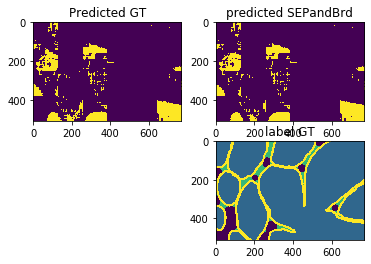

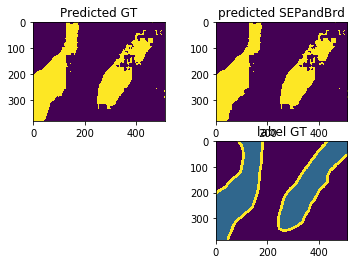

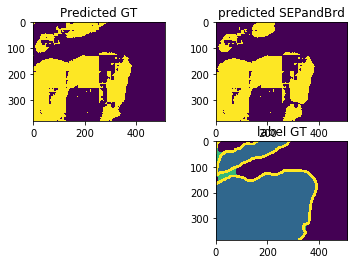

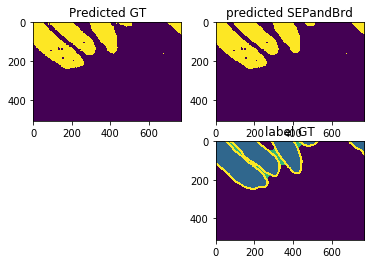

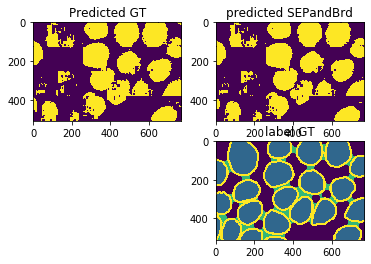

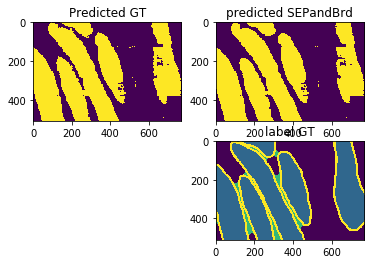

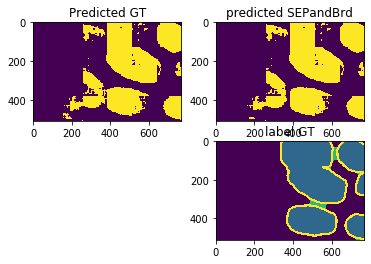

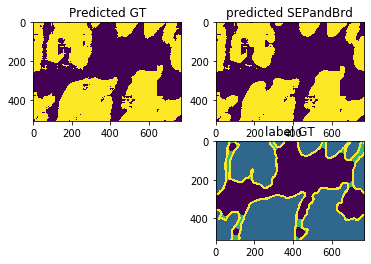

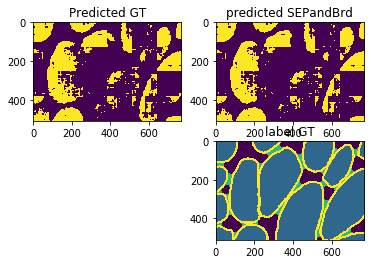

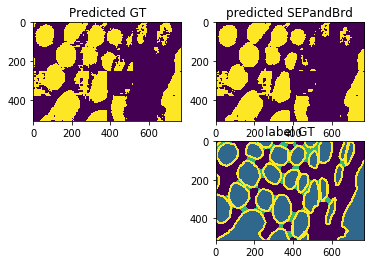

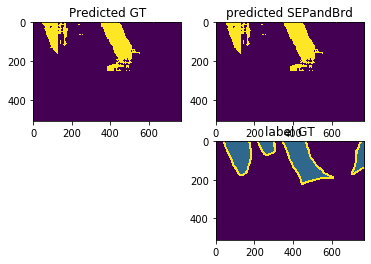

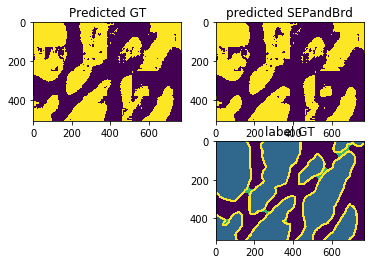

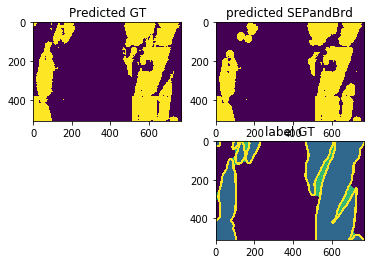

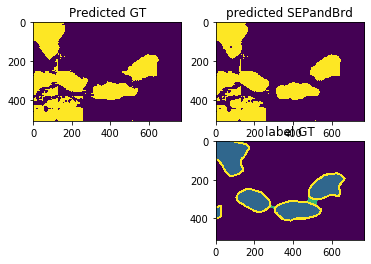

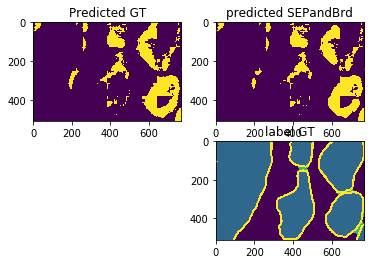

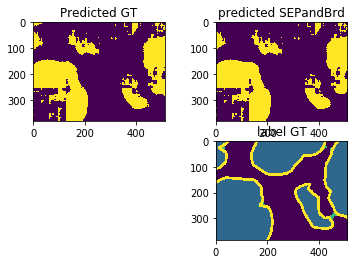

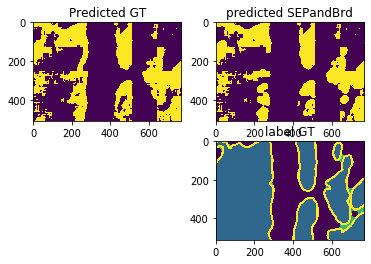

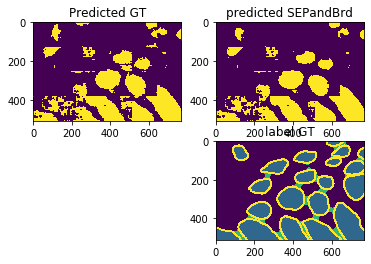

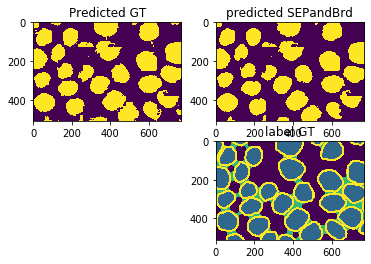

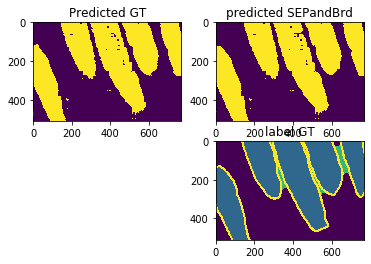

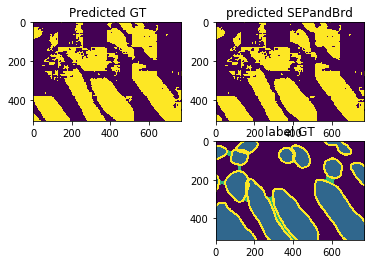

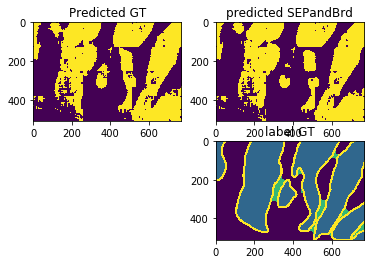

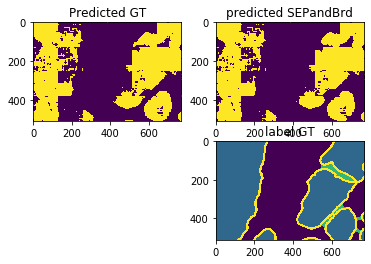

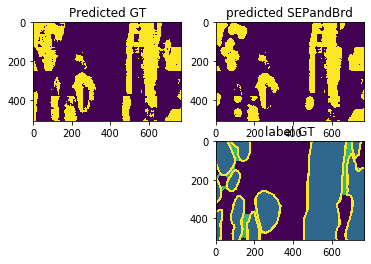

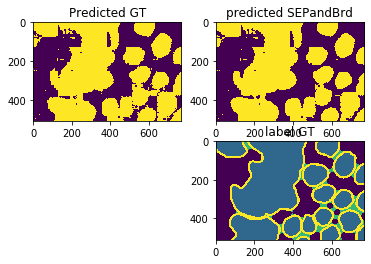

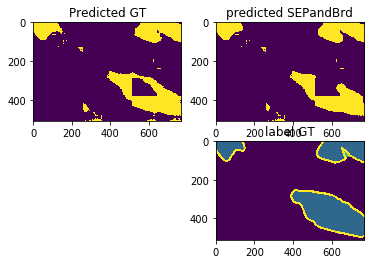

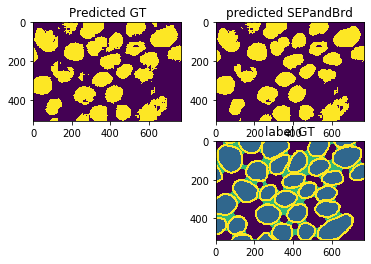

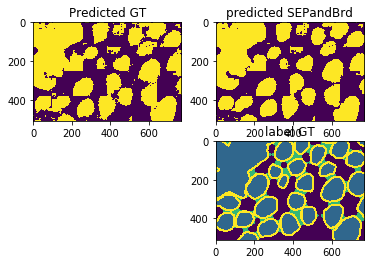

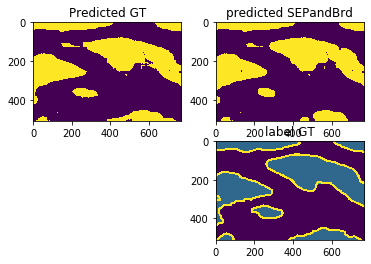

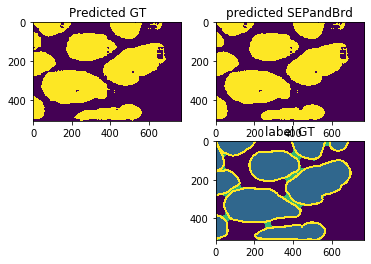

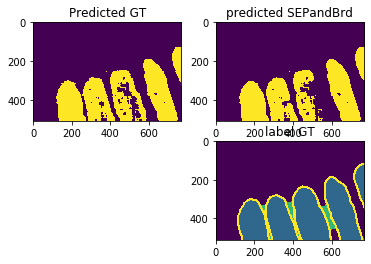

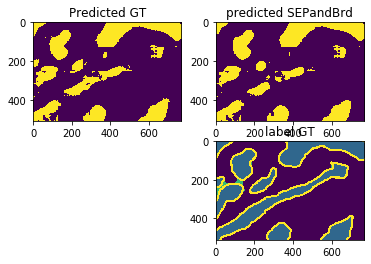

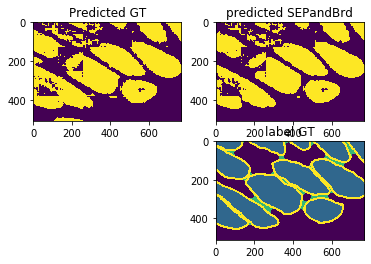

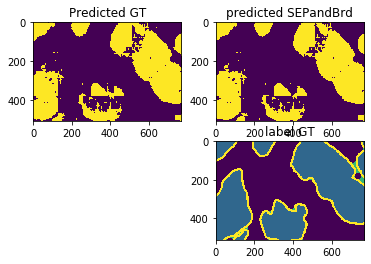

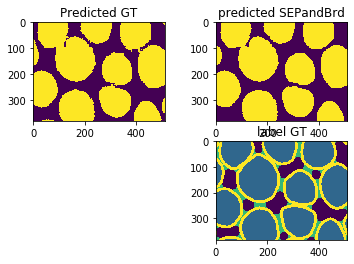

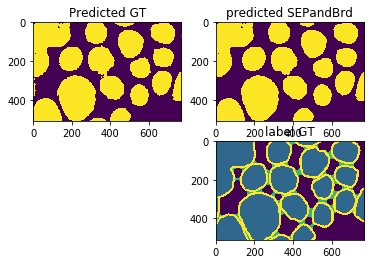

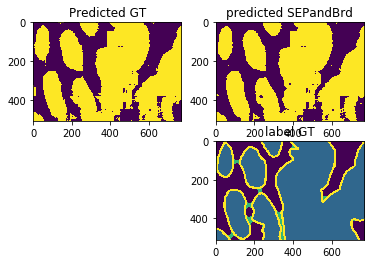

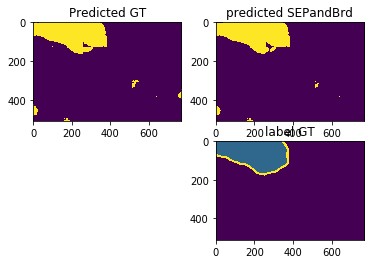

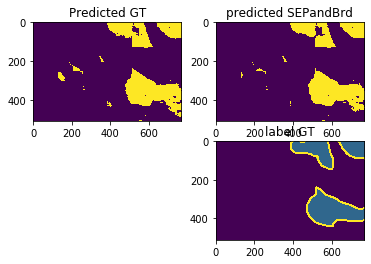

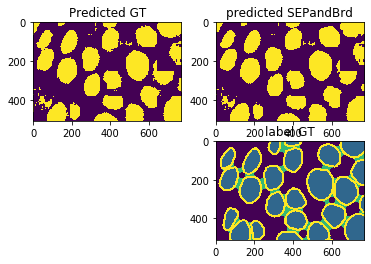

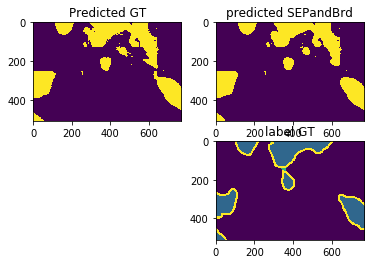

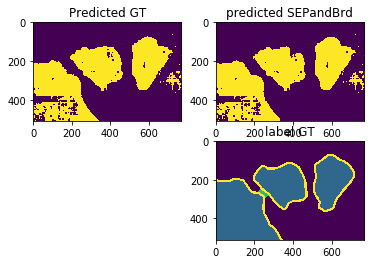

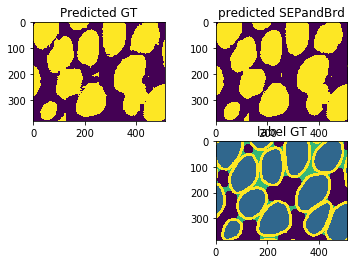

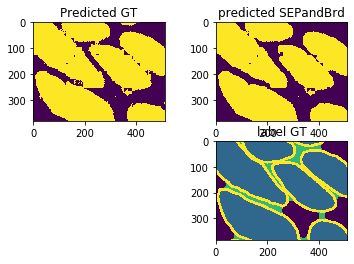

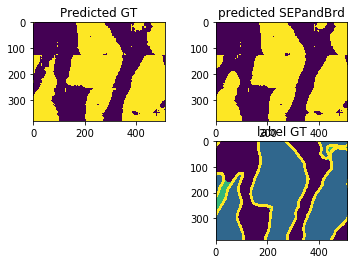

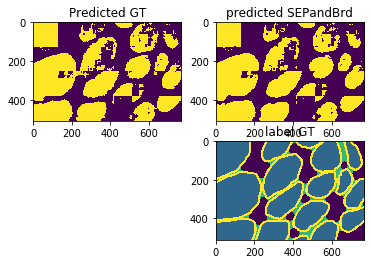

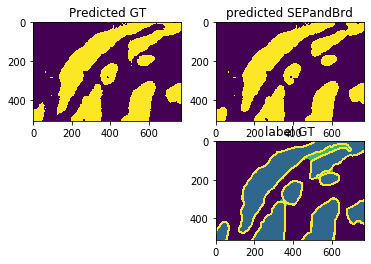

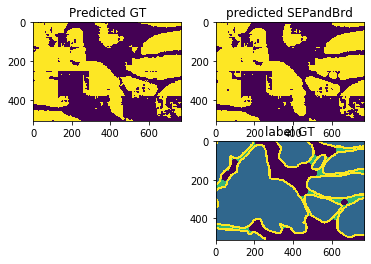

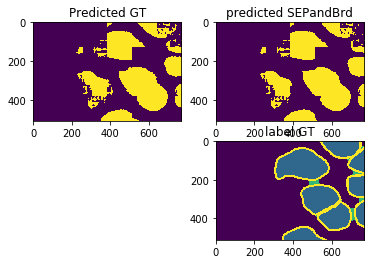

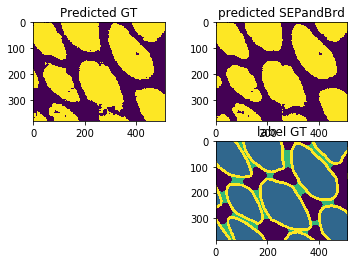

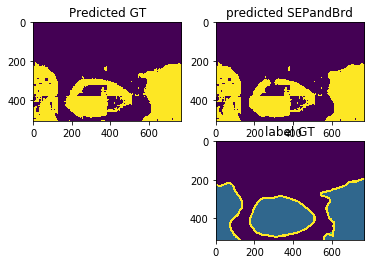

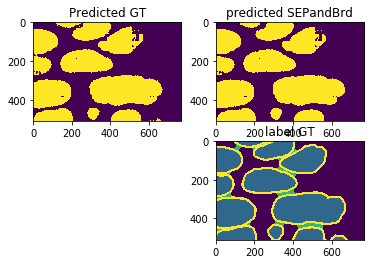

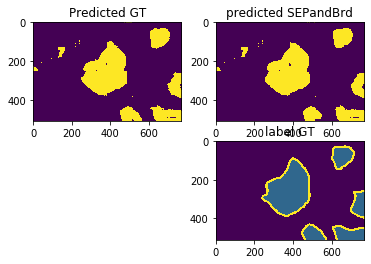

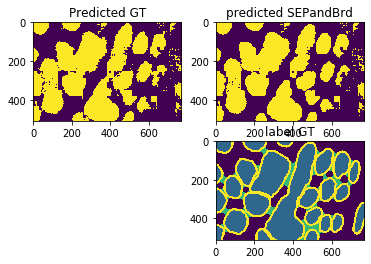

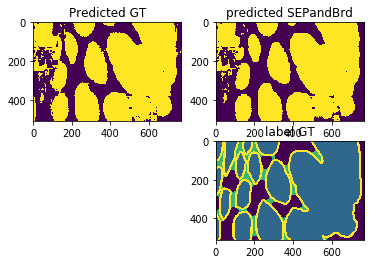

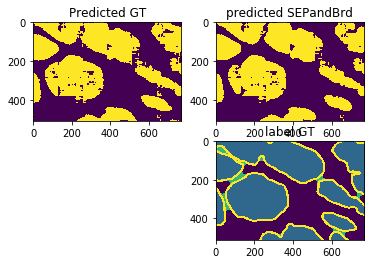

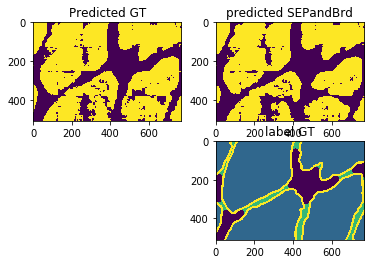

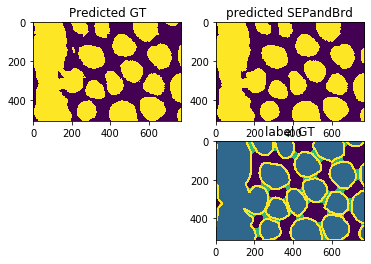

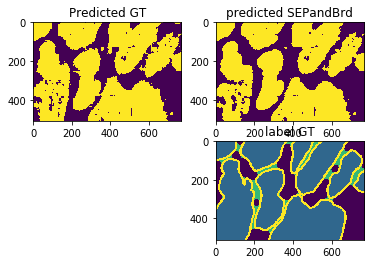

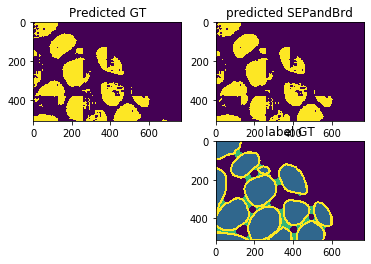

Pred initial: 0.851378042105306
pred2 (SEP): 0.8471400826039649


In [76]:
 from skimage.morphology import binary_dilation, binary_erosion, square, remove_small_objects, closing, opening, erosion


post_path = os.path.join(result_images_file % 155)

stat_dict = {  # keeps track of the evaluation results
    'tp': 0,
    'tn': 0,
    'fp': 0,
    'fn': 0
}
stat_dict2 = {  # keeps track of the evaluation results
    'tp': 0,
    'tn': 0,
    'fp': 0,
    'fn': 0
}
stat_dict3 = {  # keeps track of the evaluation results
    'tp': 0,
    'tn': 0,
    'fp': 0,
    'fn': 0
}

y_label = []
y_scores = []
train_files = 85 + 1
test_files = 60 + 1

import random
randvalue = random.randint(1, 60)

for i in range(1, test_files): 

  im_file = str(i) + '.bmp'

  im = imageio.imread(os.path.join(post_path, im_file)).astype(np.uint8) / 50

  prediction = im[:,:im.shape[1]//2]
  gt = im[:,im.shape[1]//2:]

  #Seperation channel
  prediction2 = np.copy(prediction)
  prediction2[(prediction2 > 2.5) | (prediction2 < 1.5)] = 0 
  prediction2[(prediction2 >= 1.5) & (prediction2 <= 2.5)] = 1
  prediction2 = prediction2 >0
  prediction2 = binary_dilation(prediction2, selem=disk(5))
  gt2 = np.copy(gt)
  gt2[gt2 != 2] = 0 
  gt2[gt2 == 2] = 1      

  #Edge channel
  prediction3 = np.copy(prediction)
  prediction3[(prediction3 > 3.5) | (prediction3 < 2.5)] = 0 
  prediction3[(prediction3 <= 3.5) & (prediction3 >= 2.5)] = 1 
  gt3 = np.copy(gt)
  gt3[(gt3 > 3.5) | (gt3 < 2.5)] = 0
  gt3[ (gt3 <= 3.5) & (gt3 >= 2.5)] = 1
  prediction3 = closing(closing(prediction3, selem=disk(10)), disk(10))


  prediction1 = np.copy(prediction)
  prediction1[(prediction1 > 1.5) | (prediction1 < 0.5)] = 0 
  prediction1[(prediction1 >= 0.5) & (prediction1 <= 1.5)] = 1 
  gt1 = np.copy(gt)
  gt1[ (gt1 > 1.5) | (gt1 < 0.5)] = 0
  gt1[ (gt1 <= 1.5) & (gt1 >= 0.5)] = 1

  prediction4 = prediction3 + prediction2
  prediction4 = prediction4 > 0

  prediction4 = prediction1 - prediction4
  prediction4 = prediction4 > 0

  stat_dict['tp'] += np.sum(np.logical_and(prediction1 == 1, gt1 == 1))
  stat_dict['tn'] += np.sum(np.logical_and(prediction1 == 0, gt1 == 0))
  stat_dict['fp'] += np.sum(np.logical_and(prediction1 == 1, gt1 == 0))
  stat_dict['fn'] += np.sum(np.logical_and(prediction1 == 0, gt1 == 1))

  stat_dict2['tp'] += np.sum(np.logical_and(prediction4 == 1, gt1 == 1))
  stat_dict2['tn'] += np.sum(np.logical_and(prediction4 == 0, gt1 == 0))
  stat_dict2['fp'] += np.sum(np.logical_and(prediction4 == 1, gt1 == 0))
  stat_dict2['fn'] += np.sum(np.logical_and(prediction4 == 0, gt1 == 1))

  if True:

  #if randvalue == i:
    a0 = plt.subplot(2, 2, 1)
    plt.imshow(prediction1)
    a1 = plt.subplot(2, 2, 2)
    plt.imshow(prediction4)
    a3 = plt.subplot(2, 2, 4)
    plt.imshow(gt)
    a0.title.set_text('Predicted GT')
    a1.title.set_text('predicted SEPandBrd')
    a3.title.set_text('label GT')
    plt.show()

print("Pred initial: " + str(float(2 * stat_dict['tp'] + 1) / ((2 * stat_dict['tp']) + (stat_dict['fp'] + stat_dict['fn']) + 1)))

print("pred2 (SEP): " + str(float(2 * stat_dict2['tp'] + 1) / ((2 * stat_dict2['tp']) + (stat_dict2['fp'] + stat_dict2['fn']) + 1)))


